In [209]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from nltk.tokenize import word_tokenize
import pickle
import string
from string import punctuation
import os
%matplotlib inline
sns.set_style("darkgrid")

In [216]:
#Details for getting data from projectfinder
db_loc = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'database' : 'projectfinder',
    'collection' : 'itproject_clean'
}

In [217]:
pickle_in = open('constants/stopwords.pickle',"rb")
stopwords_all = pickle.load(pickle_in)

In [218]:
months = ['Januar', 'January','Februar', 'February', 'März', 'March', 'April', 'Mai', 'May', 'Juni', 'June', 'Juli', 
          'July', 'August', 'September', 'Oktober', 'October', 'November', 'Dezember', 'December']
months = [month.lower() for month in months]
print(months)

['januar', 'january', 'februar', 'february', 'märz', 'march', 'april', 'mai', 'may', 'juni', 'june', 'juli', 'july', 'august', 'september', 'oktober', 'october', 'november', 'dezember', 'december']


In [219]:
#german cities
from scripts_mod.bundeslander import Baden_Württemberg, Bayern, Berlin, Brandenburg, Bremen, Hamburg, Hessen, Mecklenburg_Vorpommern, Niedersachsen, Nordrhein_Westfalen, Rheinland_Pfalz, Saarland, Sachsen, Sachsen_Anhalt, Schleswig_Holstein, Thüringen, Ausland

All = Baden_Württemberg + Bayern + Berlin + Brandenburg + Bremen +Hamburg + Hessen + Mecklenburg_Vorpommern + Niedersachsen + Nordrhein_Westfalen + Rheinland_Pfalz + Saarland + Sachsen + Sachsen_Anhalt + Schleswig_Holstein + Thüringen + Ausland
cities = list(set([city.lower() for city in All]))

In [221]:
unknown = ['gesuchtnone','münchennone','hamburgnone''roll','senior', 'junior','freiberuflicher','freiberufliches_projekt','hannovernone','region','gender_none','sfdc','gebäuden','home','gutscheine','nan','none','monat','verantwortung','freiberufliche','experte','freiberuflicher','freelancer','produkt','thema','einarbeitung','rolle', 'konzept', 'vertrieb','bjc_best','teilweise','freelancer','senior','art','reisebereitschaft','mm_freiberufler','knowhow','mitte','user','systems','system', 'systeme','internen','leitung','steuerung','application','arbeit','handelt','führen','verschiedene','freelancer','verantwortlich','themen', 'thema','freiberufler','gutschein','huber_computerfutures','nagios','portfolios','fachlich_portfolios','verfügen','scenarios','aa_anastasios','themen','beschrieben','gesetzlichen','telefonnummer_tagsüber','thorough','world','spät','charm','hauptbuch','sandra_kreutzer','manner','journey','due','monatlich','daily','care','old','farm','hi','franziska_koch','san','zoll','diagrams','deal','expect','reichen','offene','kreis','zeiten','immediate','challenge','funds','bit_bit','schnelle_antwort','forward','look','mystery_shopper','better','trained','gender_ffm','termin','müller','xing','hello','enjoy','summary','stand_ups','tagen_volle','rebecca_brian','track','solman','agreements','next_step','iatf','tobias_seeger','target','beneficial','phone','dis','persons','facilitating','nationalen','kvp','ständig_freelancer','manager_jana',"zb","persnlich","abgeschloss","futur", "druck",'hamburger',"teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung' ]


In [222]:
stopwords_all = list(set(stopwords_all + cities + months + unknown))
len(stopwords_all)

13365

In [349]:
with open('constants/stopwords_all.pickle', 'wb') as output:
    pickle.dump(stopwords_all, output)

In [223]:
def load_dataset_from_momgodb(db_obj):
    
    """
    This method loads a dataset as a pandas dataframe from MongoDB 
    
    Parameters:
    @db_obj (dict): Storing the ip address, port number, database name and collection name for dataset to be loaded
    
    Returns:
    panadas dataframe: Containing the loaded dataset
    """
    
    #Extracting the items from the inputted dictionary
    dbname = db_obj['database']
    ip = db_obj['ip']
    port = db_obj['port']
    collection = db_obj['collection']
    
    #Creating a connection to the database using MongoClient
    connection = MongoClient(ip, port)
    db = connection[dbname]
    
    #Excluding the fileds which are not needed in the dataframe 
    #Currenlty excluding the id associated with each document of the collection
    
    exclude_field = {'_id': False}
    raw_dataset = list(db[collection].find({}, projection=exclude_field))
    
    dataset = pd.DataFrame(raw_dataset)
    print(f'Data loaded from mongodb {collection} collection succesfully')
    return dataset

In [224]:
df = load_dataset_from_momgodb(db_loc)
df.head()

Data loaded from mongodb itproject_clean collection succesfully


,category,person_count,description,scrapy-mongodb,title,date_post,pid,date_end,date_start,filter_date_end,...,duration,filter_date_post,contact_person,location,svm_label,skill_summary,region,bereich,skillssummary,cockpit
0,IT,1,Für einen unserer Kunden aus dem Finanzdienstl...,{'ts': 2017-09-15 07:01:17.517000},IT Berater (m/w) für bankfachliche Anwendungen...,12.09.2017,521158,None,09.2017,None,...,None,2017-09-12 00:00:00,None,Frankfurt / Hannover / Münster,Software Engineering,"[support, administration, kreditgeschäft, bank...","{'bundesland': 'Nordrhein-Westfalen', 'stadt':...",Infr-Admin-Microsoft,NaN,NaN
1,Consulting,1,Kann Profil leider nicht löschen.,{'ts': 2017-09-19 22:41:50.659000},Hier nicht mehr aktiv,19.09.2017,528074,None,None,None,...,None,2017-09-19 00:00:00,None,None,IT,[],NaN,IT/Consulting,NaN,NaN
2,Consulting IT,1,Business Intelligence Analyst (m/w) - Tableau ...,{'ts': 2017-11-06 23:36:21.480000},Business Intelligence Analyst (m/w) - Tableau ...,04.11.0017,531481,None,01.2018,None,...,None,0017-11-04 00:00:00,None,Frankfurt am Main,IT,[tableau],"{'bundesland': 'Hessen', 'stadt': 'Frankfurt'}",Data-Sci-BI,NaN,NaN
3,Dienstleistung,1,"Konzeption, Customizing sowie Softwareanpassun...",{'ts': 2017-11-10 23:00:49.827000},Developer - Talend ESB oder Apache Camel (m/w)...,None,6651,None,asap,None,...,6 Monate,2017-11-11 00:00:00,David Lam,Schleswig-Holstein - IT,IT,"[, implementierung, ms sql, camel, requirement...",NaN,Infr-Admin-Linux,NaN,NaN
4,IT,1,Es sollen mehrere Automatisierungen mit ubot S...,{'ts': 2017-11-16 23:03:59.133000},Erstellung von Automatisierungen mit ubot studio,16.11.2017,532480,None,12.2017,None,...,None,2017-11-16 00:00:00,None,None,IT,[ubot software automatisierung],NaN,IT/IT,NaN,NaN


In [225]:
df.shape

(14059, 25)

In [226]:
df['ready'] = df.skill_summary.astype(str).str.replace('\[|\]|\'', '')

In [227]:
data = df[['ready', 'skill_summary', 'title']]

In [228]:
data.head()

,ready,skill_summary,title
0,"support, administration, kreditgeschäft, bank,...","[support, administration, kreditgeschäft, bank...",IT Berater (m/w) für bankfachliche Anwendungen...
1,,[],Hier nicht mehr aktiv
2,tableau,[tableau],Business Intelligence Analyst (m/w) - Tableau ...
3,", implementierung, ms sql, camel, requirements...","[, implementierung, ms sql, camel, requirement...",Developer - Talend ESB oder Apache Camel (m/w)...
4,ubot software automatisierung,[ubot software automatisierung],Erstellung von Automatisierungen mit ubot studio


In [229]:
data["combined"] = data["title"].map(str) + ' ' + data["ready"]
data.head()

/home/ki/.conda/envs/pf-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ready,skill_summary,title,combined
0,"support, administration, kreditgeschäft, bank,...","[support, administration, kreditgeschäft, bank...",IT Berater (m/w) für bankfachliche Anwendungen...,IT Berater (m/w) für bankfachliche Anwendungen...
1,,[],Hier nicht mehr aktiv,Hier nicht mehr aktiv
2,tableau,[tableau],Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...
3,", implementierung, ms sql, camel, requirements...","[, implementierung, ms sql, camel, requirement...",Developer - Talend ESB oder Apache Camel (m/w)...,Developer - Talend ESB oder Apache Camel (m/w)...
4,ubot software automatisierung,[ubot software automatisierung],Erstellung von Automatisierungen mit ubot studio,Erstellung von Automatisierungen mit ubot stud...


In [245]:
data.iloc[2, 3]

'Business Intelligence Analyst (m/w) - Tableau Desktop - FFM tableau'

In [246]:
data.iloc[2, 2]

'Business Intelligence Analyst (m/w) - Tableau Desktop - FFM'

In [247]:
for word in data['combined']:
    for t in word:
        if 'frankfurtnone' in t:
            print(t)

In [249]:
def text_processing(text):
    """Normalize, tokenize, stem the original text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    cleaned: list of strings. List containing normalized and stemmed word tokens with bigrams
    """

    try:
        text = re.sub(r'(\d)',' ',text.lower())
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        tokens = word_tokenize(text)
        tokens_cleaned = [word for word in tokens if word not in stopwords_all and len(word) > 1]
        
    except IndexError:
        pass

    return tokens_cleaned

In [250]:
# Clean text and title and create new column "tokenized"
t1 = time.time()
data['tokenized'] = data['combined'].apply(text_processing)
t2 = time.time()

/home/ki/.conda/envs/pf-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
data.head()

,ready,skill_summary,title,combined,tokenized
0,"support, administration, kreditgeschäft, bank,...","[support, administration, kreditgeschäft, bank...",IT Berater (m/w) für bankfachliche Anwendungen...,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,..."
1,,[],Hier nicht mehr aktiv,Hier nicht mehr aktiv,[]
2,tableau,[tableau],Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des..."
3,", implementierung, ms sql, camel, requirements...","[, implementierung, ms sql, camel, requirement...",Developer - Talend ESB oder Apache Camel (m/w)...,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem..."
4,ubot software automatisierung,[ubot software automatisierung],Erstellung von Automatisierungen mit ubot studio,Erstellung von Automatisierungen mit ubot stud...,"[automatisierungen, ubot, studio, ubot, softwa..."


In [254]:
for word in data['tokenized']:
    for t in word:
        if 'none' in t:
            print(t)

In [255]:
new_data = data[['title', 'tokenized']]
new_data.head()

,title,tokenized
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,..."
1,Hier nicht mehr aktiv,[]
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa..."


In [256]:
new_data.shape

(14059, 2)

In [257]:
new_data= new_data[new_data['tokenized'].map(len) >1]
new_data.shape

(13140, 2)

In [258]:
new_data.head()

,title,tokenized
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,..."
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa..."
5,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]"


In [259]:
for word in new_data['tokenized']:
    for t in word:
        if 'none' in t:
            print(t)

In [260]:
bigram = gensim.models.Phrases(new_data['tokenized'].tolist(), min_count=2, threshold=2) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_mod.save('models/bigram_skills_title')

/home/ki/.conda/envs/pf-env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [261]:
from gensim.utils import SaveLoad
load_bigrams = SaveLoad.load('models/bigram_skills_title')
def make_bigrams(text):
    return load_bigrams[text]

In [262]:
# Form Bigrams
new_data['token_stem_spRm_bigram'] = new_data['tokenized'].apply(make_bigrams)

In [263]:
new_data.head(20)

,title,tokenized,token_stem_spRm_bigram
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,...","[berater, bankfachliche, anwendungen, support,..."
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des...","[business_intelligence, analyst, tableau, desk..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem...","[developer, talend, esb, apache_camel, impleme..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa...","[automatisierungen, ubot, studio, ubot, softwa..."
5,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]"
7,IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"[support, support, windows, ios, mobile, offic...","[support, support, windows, ios_mobile, office..."
8,Consultant für Microsoft Dynamics CRM (m/w),"[consultant, microsoft, crm, crm, crm, crm, cr...","[consultant_microsoft, crm_crm, crm_crm, crm_crm]"
9,Java Senior Developer - Backend (f/m),"[java, developer, backend, hibernate, java, or...","[java_developer, backend, hibernate_java, orac..."
10,DMS - CMS Consultant mit großer Prozeßerfahrun...,"[dms, cms, consultant, großer, prozeßerfahrung...","[dms, cms, consultant, großer, prozeßerfahrung..."
11,IntQunet,"[intqunet, drupal]","[intqunet, drupal]"


In [265]:
def remove_duplicates(text):
    return list(set(text))

In [266]:
# Form Bigrams
new_data['cleaned'] = new_data['token_stem_spRm_bigram'].apply(remove_duplicates)

In [267]:
new_data.head(20)

,title,tokenized,token_stem_spRm_bigram,cleaned
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,...","[berater, bankfachliche, anwendungen, support,...","[anwendungen, berater, support_administration,..."
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des...","[business_intelligence, analyst, tableau, desk...","[tableau, business_intelligence, ffm, desktop,..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem...","[developer, talend, esb, apache_camel, impleme...","[apache_camel, testautomatisierung, entwicklun..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa...","[automatisierungen, ubot, studio, ubot, softwa...","[studio, software, automatisierungen, automati..."
5,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]"
7,IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"[support, support, windows, ios, mobile, offic...","[support, support, windows, ios_mobile, office...","[android, support, outlook, win, windows, offi..."
8,Consultant für Microsoft Dynamics CRM (m/w),"[consultant, microsoft, crm, crm, crm, crm, cr...","[consultant_microsoft, crm_crm, crm_crm, crm_crm]","[consultant_microsoft, crm_crm]"
9,Java Senior Developer - Backend (f/m),"[java, developer, backend, hibernate, java, or...","[java_developer, backend, hibernate_java, orac...","[db, oracle_oracle, nginx, server, angular, or..."
10,DMS - CMS Consultant mit großer Prozeßerfahrun...,"[dms, cms, consultant, großer, prozeßerfahrung...","[dms, cms, consultant, großer, prozeßerfahrung...","[visual_basic, dms, cms, hardware, wordpress, ..."
11,IntQunet,"[intqunet, drupal]","[intqunet, drupal]","[intqunet, drupal]"


In [268]:
for word in new_data['cleaned']:
    for t in word:
        if 'none' in t:
            print(t)

In [269]:
# first get a list of all words
words_in_df = [word for item in list(new_data['cleaned']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(words_in_df)
len(fdist) # number of unique words

8356

In [272]:
#the bottom 10 words of the top 14000 words in df
top_k_words = fdist.most_common(2000)
top_k_words[-20:]

[('idms', 5),
 ('logistics', 5),
 ('architect_security', 5),
 ('administration_hadoop', 5),
 ('visual', 5),
 ('tv', 5),
 ('sr', 5),
 ('exchange_backup', 5),
 ('requirementsengineer', 5),
 ('kundenorientiert', 5),
 ('industrial', 5),
 ('teamlead', 5),
 ('entwickler_nord', 5),
 ('windows_admin', 5),
 ('remoteoption', 5),
 ('pn', 5),
 ('project_leader', 5),
 ('teilfachbauleiter', 5),
 ('bergkristall_data', 5),
 ('plc', 5)]

In [273]:
k = 2000
unknown = ['gesuchtnone','münchennone','hamburgnone''roll','senior', 'junior','freiberuflicher','freiberufliches_projekt','hannovernone','region','gender_none','sfdc','gebäuden','home','gutscheine','nan','none','monat','verantwortung','freiberufliche','experte','freiberuflicher','freelancer','produkt','thema','einarbeitung','rolle', 'konzept', 'vertrieb','bjc_best','teilweise','freelancer','senior','art','reisebereitschaft','mm_freiberufler','knowhow','mitte','user','systems','system', 'systeme','internen','leitung','steuerung','application','arbeit','handelt','führen','verschiedene','freelancer','verantwortlich','themen', 'thema','freiberufler','gutschein','huber_computerfutures','nagios','portfolios','fachlich_portfolios','verfügen','scenarios','aa_anastasios','themen','beschrieben','gesetzlichen','telefonnummer_tagsüber','thorough','world','spät','charm','hauptbuch','sandra_kreutzer','manner','journey','due','monatlich','daily','care','old','farm','hi','franziska_koch','san','zoll','diagrams','deal','expect','reichen','offene','kreis','zeiten','immediate','challenge','funds','bit_bit','schnelle_antwort','forward','look','mystery_shopper','better','trained','gender_ffm','termin','müller','xing','hello','enjoy','summary','stand_ups','tagen_volle','rebecca_brian','track','solman','agreements','next_step','iatf','tobias_seeger','target','beneficial','phone','dis','persons','facilitating','nationalen','kvp','ständig_freelancer','manager_jana',"zb","persnlich","abgeschloss","futur", "druck",'hamburger',"teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung' ]
top_words = zip(*fdist.most_common(k))
top_words = set(top_words)
top_words = {word for sent in top_words for word in sent if type(word) == str}
top_words = {word for word in top_words if word not in unknown}
top_words

{'payroll',
 'typescript',
 'test_ingenieur',
 'cloud_computing',
 'app_entwicklung',
 'dokumentation',
 'edm',
 'gradle',
 'prozessoptimierung_softwaretechnik',
 'cissp',
 'subversion',
 'beckhoff',
 'netzwerktechniker',
 'windows_administration',
 'java_scala',
 'full',
 'java_intellij',
 'sap_successfactors',
 'fpga',
 'datenbankanbindung',
 'openshift',
 'istqb_test',
 'sybase',
 'host',
 'elektro',
 'integrity',
 'cloud_platform',
 'bpc',
 'ajax',
 'citrix_xenapp',
 'program',
 'parttime',
 'informatikkaufmann',
 'mm_wm',
 'jenkins',
 'dringende_projektanfrage',
 'pw',
 'retail',
 'sap_psm',
 'dokumentation_monitoring',
 'diagnose',
 'netapp',
 'desktop',
 'cluster',
 'simulink',
 'configuration_manager',
 'prozessberater_sap',
 'java_developer',
 'profound',
 'cr_beratung',
 'bauingenieur',
 'angular',
 'zertifizierung_itil',
 'microservice',
 'powershell_vmware',
 'inbetriebnehmer',
 'aem',
 'administrative',
 'softwarearchitekt',
 'continuous_integration',
 'supporter_installat

In [274]:
def most_appeared(text):
    return [word for word in text if word in top_words]

In [275]:
new_data['cleaned'].apply(most_appeared)
new_data.head()

,title,tokenized,token_stem_spRm_bigram,cleaned
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,...","[berater, bankfachliche, anwendungen, support,...","[anwendungen, berater, support_administration,..."
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des...","[business_intelligence, analyst, tableau, desk...","[tableau, business_intelligence, ffm, desktop,..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem...","[developer, talend, esb, apache_camel, impleme...","[apache_camel, testautomatisierung, entwicklun..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa...","[automatisierungen, ubot, studio, ubot, softwa...","[studio, software, automatisierungen, automati..."
5,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]"


In [276]:
# document length
new_data['doc_len'] = new_data['cleaned'].apply(lambda x: len(x))
doc_lengths = list(new_data['doc_len'])
new_data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 13140 
average document length 4.704794520547945 
minimum document length 1 
maximum document length 41


In [277]:
# create a mask of binary values
msk = np.random.rand(len(new_data)) < 0.9980
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [278]:
train_df = new_data[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = new_data[~msk]
test_df.reset_index(drop=True,inplace=True)

In [279]:
print(len(df),len(train_df),len(test_df))

14059 13116 24


In [280]:
dictionary1 = corpora.Dictionary(train_df['cleaned'])
corpus1 = [dictionary1.doc2bow(doc) for doc in train_df['cleaned']]


In [286]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus1, num_topics=32, id2word=dictionary1)

In [294]:
# Save model to disk.
ldamallet.save('models/ldamallet_model_skills_title_32_1')

In [295]:
from gensim.models import CoherenceModel
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=new_data['cleaned'], dictionary=dictionary1, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.45014921543463376


In [296]:
# Load a potentially pretrained model from disk.
ldamallet_loaded_32 = LdaMallet.load('models/ldamallet_model_skills_title_32_1')

In [290]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [291]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary1, corpus=corpus1, texts=new_data['cleaned'], start=2, limit=40, step=6)

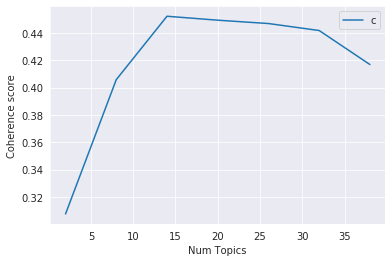

In [292]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [293]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3075
Num Topics = 8  has Coherence Value of 0.4059
Num Topics = 14  has Coherence Value of 0.4523
Num Topics = 20  has Coherence Value of 0.4494
Num Topics = 26  has Coherence Value of 0.447
Num Topics = 32  has Coherence Value of 0.4418
Num Topics = 38  has Coherence Value of 0.4169


In [297]:
from gensim.models import CoherenceModel
import pprint
pp = pprint.PrettyPrinter(indent=4)
# Show Topics
pp.pprint(ldamallet_loaded_32.show_topics(num_topics=32, num_words=15, formatted=False))


[   (   0,
        [   ('angular', 0.10609816559246406),
            ('developer', 0.07535944471988101),
            ('js', 0.047595438770451165),
            ('node_js', 0.033217649975210706),
            ('frontend', 0.03272186415468518),
            ('full_stack', 0.030738720872583045),
            ('fullstack_entwickler', 0.029747149231531978),
            ('frontend_developer', 0.02825979176995538),
            ('java_developer', 0.025780862667327716),
            ('stack', 0.023797719385225583),
            ('react', 0.02181457610312345),
            ('react_js', 0.01636093207734259),
            ('fullstack', 0.014377788795240456),
            ('angular_js', 0.013882002974714923),
            ('front', 0.011898859692612791)]),
    (   1,
        [   ('entwickler', 0.2737246297312123),
            ('abap', 0.07515085024684585),
            ('ui', 0.05924300603400987),
            ('sap_abap', 0.04827207899067471),
            ('abap_entwickler', 0.021393307734503566),
           

In [306]:
ldamallet25 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus1, num_topics=25, id2word=dictionary1)

In [307]:
from gensim.models import CoherenceModel
import pprint
pp = pprint.PrettyPrinter(indent=4)
# Show Topics
pp.pprint(ldamallet25.show_topics(num_topics=25, num_words=15, formatted=False))

[   (   0,
        [   ('sap', 0.17875145405195814),
            ('berater', 0.14773167894532765),
            ('sap_fi', 0.06397828615742536),
            ('sap_hana', 0.03412175261729353),
            ('fi', 0.033734005428460646),
            ('sap_bw', 0.03218301667312912),
            ('hana', 0.029856533540131833),
            ('fi_sap', 0.02791779759596743),
            ('finance', 0.021713842574641335),
            ('sap_pp', 0.021713842574641335),
            ('bw', 0.018611865063978286),
            ('hana_sap', 0.017836370686312525),
            ('berater_hana', 0.014346645986816595),
            ('scm', 0.0081426909654905),
            ('rechnungswesen', 0.0081426909654905)]),
    (   1,
        [   ('spezialist', 0.10106609808102346),
            ('architekt', 0.07334754797441365),
            ('lead', 0.0396588486140725),
            ('project', 0.03667377398720682),
            ('citrix', 0.03070362473347548),
            ('java_jee', 0.029424307036247335),
            ('

In [308]:
from gensim.models import CoherenceModel
import pprint
pp = pprint.PrettyPrinter(indent=4)
# Show Topics
pp.pprint(ldamallet26.show_topics(num_topics=26, num_words=15, formatted=False))

[   (   0,
        [   ('ms_office', 0.06714095153401511),
            ('beratung', 0.0658070253445976),
            ('meldewesen', 0.048465984882169855),
            ('excel', 0.04357492218763895),
            ('pmo', 0.029346376167185415),
            ('analyse', 0.029346376167185415),
            ('finance', 0.026233881725211204),
            ('projekt_beratungsleistung', 0.023566029346376166),
            ('accounting', 0.023566029346376166),
            ('banking', 0.018674966651845263),
            ('schulung', 0.01823032458870609),
            ('finance_management', 0.0164517563361494),
            ('sas', 0.013783903957314362),
            ('controller', 0.010226767452200978),
            ('accounting_sap', 0.009782125389061804)]),
    (   1,
        [   ('sql', 0.13817427385892117),
            ('datenbank', 0.053526970954356844),
            ('data', 0.04979253112033195),
            ('sql_server', 0.036929460580912864),
            ('ms_sql', 0.036929460580912864),
         

In [309]:
# Save model to disk.
ldamallet26.save('models_app//ldamallet_model_skills_title_26_pref')

In [ ]:
# Save model to disk.
ldamallet26.save('models/ldamallet_model_skills_title_26_pref')

In [310]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus1, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [311]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet26, corpus=corpus1, texts=train_df['cleaned'])

In [312]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.0600,"support, windows, office, konfiguration, deplo...","[anwendungen, berater, support_administration,..."
1,1,11.0,0.0653,"projekt, manager, crm, jira, analyst, marketin...","[tableau, business_intelligence, ffm, desktop,..."
2,2,19.0,0.0761,"analyse, design, business_analyst, dokumentati...","[apache_camel, testautomatisierung, entwicklun..."
3,3,17.0,0.0592,"test, tester, automatisierung, testautomatisie...","[studio, software, automatisierungen, automati..."
4,4,21.0,0.0519,"projektmanagement, projektleiter, projektmanag...","[spieleentwickler, hardwarekenntnissen]"
5,5,7.0,0.1176,"support, windows, office, konfiguration, deplo...","[android, support, outlook, win, windows, offi..."
6,6,7.0,0.0562,"support, windows, office, konfiguration, deplo...","[consultant_microsoft, crm_crm]"
7,7,3.0,0.0925,"java, java_entwickler, jee, spring, java_devel...","[db, oracle_oracle, nginx, server, angular, or..."
8,8,9.0,0.0654,"entwicklung, java, angular, entwickler, web, u...","[visual_basic, dms, cms, hardware, wordpress, ..."
9,9,19.0,0.0541,"analyse, design, business_analyst, dokumentati...","[intqunet, drupal]"


In [313]:
df_dominant_topic.drop('Document_No', axis=1, inplace=True)

In [314]:
df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,7.0,0.0600,"support, windows, office, konfiguration, deplo...","[anwendungen, berater, support_administration,..."
1,11.0,0.0653,"projekt, manager, crm, jira, analyst, marketin...","[tableau, business_intelligence, ffm, desktop,..."
2,19.0,0.0761,"analyse, design, business_analyst, dokumentati...","[apache_camel, testautomatisierung, entwicklun..."
3,17.0,0.0592,"test, tester, automatisierung, testautomatisie...","[studio, software, automatisierungen, automati..."
4,21.0,0.0519,"projektmanagement, projektleiter, projektmanag...","[spieleentwickler, hardwarekenntnissen]"
5,7.0,0.1176,"support, windows, office, konfiguration, deplo...","[android, support, outlook, win, windows, offi..."
6,7.0,0.0562,"support, windows, office, konfiguration, deplo...","[consultant_microsoft, crm_crm]"
7,3.0,0.0925,"java, java_entwickler, jee, spring, java_devel...","[db, oracle_oracle, nginx, server, angular, or..."
8,9.0,0.0654,"entwicklung, java, angular, entwickler, web, u...","[visual_basic, dms, cms, hardware, wordpress, ..."
9,19.0,0.0541,"analyse, design, business_analyst, dokumentati...","[intqunet, drupal]"


In [315]:
new_data.head()

,title,tokenized,token_stem_spRm_bigram,cleaned
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,...","[berater, bankfachliche, anwendungen, support,...","[anwendungen, berater, support_administration,..."
2,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des...","[business_intelligence, analyst, tableau, desk...","[tableau, business_intelligence, ffm, desktop,..."
3,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem...","[developer, talend, esb, apache_camel, impleme...","[apache_camel, testautomatisierung, entwicklun..."
4,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa...","[automatisierungen, ubot, studio, ubot, softwa...","[studio, software, automatisierungen, automati..."
5,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]"


In [316]:
test_data = df[['title', 'description']]
test_data.head()

,title,description
0,IT Berater (m/w) für bankfachliche Anwendungen...,Für einen unserer Kunden aus dem Finanzdienstl...
1,Hier nicht mehr aktiv,Kann Profil leider nicht löschen.
2,Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...
3,Developer - Talend ESB oder Apache Camel (m/w)...,"Konzeption, Customizing sowie Softwareanpassun..."
4,Erstellung von Automatisierungen mit ubot studio,Es sollen mehrere Automatisierungen mit ubot S...


In [318]:
df_topic_sents_keywords1 = format_topics_sentences(ldamodel=ldamallet26, corpus=corpus1, texts=test_data['description'])

/home/ki/.conda/envs/pf-env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [319]:
# Format
df_dominant_topic1 = df_topic_sents_keywords1.reset_index()
df_dominant_topic1.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic1.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.0600,"support, windows, office, konfiguration, deplo...",Für einen unserer Kunden aus dem Finanzdienstl...
1,1,11.0,0.0653,"projekt, manager, crm, jira, analyst, marketin...",Kann Profil leider nicht löschen.
2,2,19.0,0.0761,"analyse, design, business_analyst, dokumentati...",Business Intelligence Analyst (m/w) - Tableau ...
3,3,17.0,0.0592,"test, tester, automatisierung, testautomatisie...","Konzeption, Customizing sowie Softwareanpassun..."
4,4,21.0,0.0519,"projektmanagement, projektleiter, projektmanag...",Es sollen mehrere Automatisierungen mit ubot S...
5,5,7.0,0.1176,"support, windows, office, konfiguration, deplo...",Unser Projekt beinhaltet Spieleentwicklung für...
6,6,7.0,0.0562,"support, windows, office, konfiguration, deplo...",Future Consulting GmbH \r\nentscheiden Sie sic...
7,7,3.0,0.0925,"java, java_entwickler, jee, spring, java_devel...","Als Mitglied eines kleinen, dynamischen Teams ..."
8,8,9.0,0.0654,"entwicklung, java, angular, entwickler, web, u...",Über unseren Kunden: \n \n Unser Kunde ist e...
9,9,19.0,0.0541,"analyse, design, business_analyst, dokumentati...",Über unseren Kunden: \n \n Unser Kunde ist e...


In [320]:
df_dominant_topic1.drop('Document_No', axis=1, inplace=True)

In [321]:
df_dominant_topic1.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,7.0,0.0600,"support, windows, office, konfiguration, deplo...",Für einen unserer Kunden aus dem Finanzdienstl...
1,11.0,0.0653,"projekt, manager, crm, jira, analyst, marketin...",Kann Profil leider nicht löschen.
2,19.0,0.0761,"analyse, design, business_analyst, dokumentati...",Business Intelligence Analyst (m/w) - Tableau ...
3,17.0,0.0592,"test, tester, automatisierung, testautomatisie...","Konzeption, Customizing sowie Softwareanpassun..."
4,21.0,0.0519,"projektmanagement, projektleiter, projektmanag...",Es sollen mehrere Automatisierungen mit ubot S...
5,7.0,0.1176,"support, windows, office, konfiguration, deplo...",Unser Projekt beinhaltet Spieleentwicklung für...
6,7.0,0.0562,"support, windows, office, konfiguration, deplo...",Future Consulting GmbH \r\nentscheiden Sie sic...
7,3.0,0.0925,"java, java_entwickler, jee, spring, java_devel...","Als Mitglied eines kleinen, dynamischen Teams ..."
8,9.0,0.0654,"entwicklung, java, angular, entwickler, web, u...",Über unseren Kunden: \n \n Unser Kunde ist e...
9,19.0,0.0541,"analyse, design, business_analyst, dokumentati...",Über unseren Kunden: \n \n Unser Kunde ist e...


In [323]:
df_dominant_topic1.iloc[9,3]

'Über unseren Kunden: \n \xa0 \n Unser Kunde ist ein internationales IT Dienstleistungsunternehmen mit Sitz in Wien.\xa0 \n \xa0 \n Zur sofortigen Unterstützung des bestehenden Teams wird ein erfahrener\xa0 Java-Backend-Developer (f/m) \xa0gesucht. \n \xa0 \n Ihre Aufgaben: \n \n     Erhebung der Anforderungen \n     Erstellung von Konzepten und Reports sowie die Dokumentation \n     Neuentwicklung im Backend-Bereich \n      Begleitung der Projektierung und Realisierung von Aufträgen \n     Mitwirkung in allen Phasen des Softwareentwicklungsprozesses \n \n Unsere Anforderungen an Sie: \n \n      IT Ausbildung (HTL, Fachhochschule, idealerweise Universität) \n      Erfahrung in der Softwareentwicklung \n     Backend Know How:\xa0 Java EE 6/7 (JPA, CDI, EJB), Maven, relationale DBs (z.B. MSSQL, Oracle, DB2), Hibernate, Jenkins \n     idealer Weise Know How:\xa0 Ansible, Liquibase, Artifactory, RabbitMQ, Wildfly  \n     bzw im Frontend Bereich: Angular 4, Typescript, Nginx+ \n     agiles 

In [326]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
converted_model = malletmodel2ldamodel(ldamallet26, gamma_threshold=0.001, iterations=50)

In [351]:
#Save model to disk.
converted_model.save('models_app/converted_model_skills_title_26_pref')

/home/ki/.conda/envs/pf-env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [344]:
train_df.head(20)

,title,tokenized,token_stem_spRm_bigram,cleaned
0,IT Berater (m/w) für bankfachliche Anwendungen...,"[berater, bankfachliche, anwendungen, support,...","[berater, bankfachliche, anwendungen, support,...","[anwendungen, berater, support_administration,..."
1,Business Intelligence Analyst (m/w) - Tableau ...,"[business, intelligence, analyst, tableau, des...","[business_intelligence, analyst, tableau, desk...","[tableau, business_intelligence, ffm, desktop,..."
2,Developer - Talend ESB oder Apache Camel (m/w)...,"[developer, talend, esb, apache, camel, implem...","[developer, talend, esb, apache_camel, impleme...","[apache_camel, testautomatisierung, entwicklun..."
3,Erstellung von Automatisierungen mit ubot studio,"[automatisierungen, ubot, studio, ubot, softwa...","[automatisierungen, ubot, studio, ubot, softwa...","[studio, software, automatisierungen, automati..."
4,Spieleentwickler mit Hardwarekenntnissen,"[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]","[spieleentwickler, hardwarekenntnissen]"
5,IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"[support, support, windows, ios, mobile, offic...","[support, support, windows, ios_mobile, office...","[android, support, outlook, win, windows, offi..."
6,Consultant für Microsoft Dynamics CRM (m/w),"[consultant, microsoft, crm, crm, crm, crm, cr...","[consultant_microsoft, crm_crm, crm_crm, crm_crm]","[consultant_microsoft, crm_crm]"
7,Java Senior Developer - Backend (f/m),"[java, developer, backend, hibernate, java, or...","[java_developer, backend, hibernate_java, orac...","[db, oracle_oracle, nginx, server, angular, or..."
8,DMS - CMS Consultant mit großer Prozeßerfahrun...,"[dms, cms, consultant, großer, prozeßerfahrung...","[dms, cms, consultant, großer, prozeßerfahrung...","[visual_basic, dms, cms, hardware, wordpress, ..."
9,IntQunet,"[intqunet, drupal]","[intqunet, drupal]","[intqunet, drupal]"


In [345]:
bow = dictionary1.doc2bow(train_df.iloc[13,3])

In [346]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([topic[1] for topic in converted_model.get_document_topics(bow=bow)])
doc_distribution

array([0.03259452, 0.03259452, 0.08215834, 0.03259452, 0.06649283,
       0.03259452, 0.03285081, 0.04752547, 0.03285081, 0.04961729,
       0.03259452, 0.0490311 , 0.03259452, 0.04933887, 0.03259452,
       0.03259452, 0.03274262, 0.03386125, 0.03259452, 0.03461273,
       0.03259452, 0.03259452, 0.03259452, 0.03259452, 0.03259452,
       0.03259452])

In [347]:
# bar plot of topic distribution for this document
def plot_topic_dist(doc_distr, index):
    """
    This function plots the topic distrubtion for a given document
    It takes two parameters
    (1) doc_distr = type: list of floats, list of topic probability distribution in a document
    (2) index = type: int, index number of document to plot
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    fig, ax = plt.subplots(figsize=(12,8));
    # the histogram of the data
    patches = ax.bar(np.arange(len(doc_distr)), doc_distr)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Probability Score', fontsize=15)
    ax.set_title("Topic Distribution for Project in Index " + str(index), fontsize=20)
    ax.set_xticks(range(0,27))
    x_ticks_labels = range(0,27)
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=8)
    fig.tight_layout()
    return plt.show()

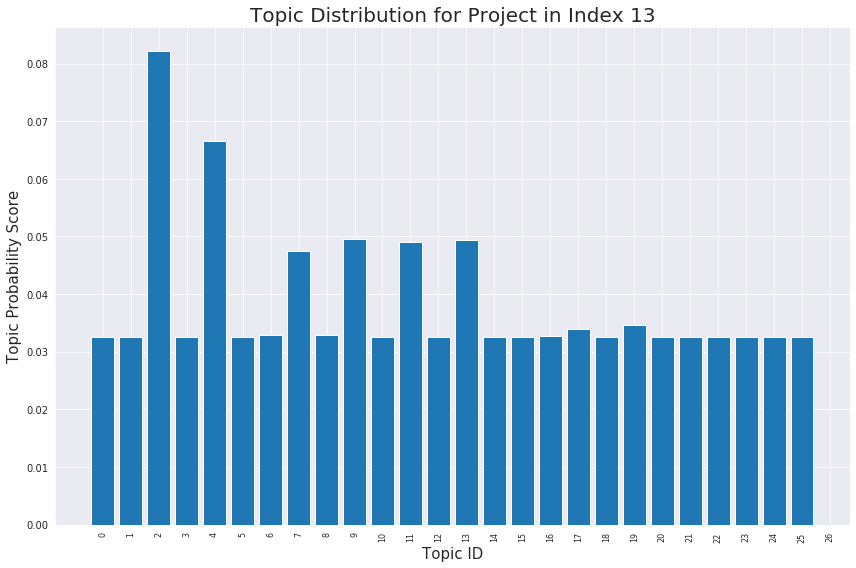

In [348]:
plot_topic_dist(doc_distribution, 13)